In [155]:
from sklearn.datasets import fetch_california_housing
import pandas as pd 
import pprint
import statsmodels.api as sm 
import warnings
import numpy as np 

In [42]:
warnings.simplefilter(category=FutureWarning,action = "ignore")

In [21]:
california_housing = fetch_california_housing()

In [151]:
data = pd.DataFrame(california_housing.data,columns=california_housing.feature_names)

In [152]:
target = pd.Series(california_housing.target*100000,name="HouseValue")

## 1. Forward Selection 
1. Choose a significance level, e.g. 0.05 with a 95% confidence
2. Fit all possible simple regression models by considering one feature at a time. Total of 'n' models are possible. Select the features with the lowest p-value.
3. Fit all possible models with one extra feature added to the previously selected features
4. repeat 2 & 3 till the intended # of features gathered or the eventual termination condition is reached

In [101]:
def forward_selection(data:pd.DataFrame(),target:pd.Series(float),significance_level:float=0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while len(initial_features)>0:
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_col in remaining_features:
            model = sm.OLS(target,sm.add_constant(data[best_features+[new_col]])).fit()
            new_pval[new_col] = model.pvalues[new_col]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break 
            
    return best_features

        

In [102]:
forward_selection(data,target)

['MedInc',
 'HouseAge',
 'Latitude',
 'Longitude',
 'AveBedrms',
 'AveRooms',
 'AveOccup']

In [103]:
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import LinearRegression

In [123]:
sfs1 = SequentialFeatureSelector(
    LinearRegression(),
    k_features=(2,8), # number of the most important features to be returned
    forward=True,
    floating=False,
    scoring="r2",
    cv=0
)

In [124]:
sfs1.fit(data,target)

SequentialFeatureSelector(cv=0, estimator=LinearRegression(), k_features=(2, 8),
                          scoring='r2')

In [125]:
sfs1.k_feature_names_

('MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude')

***

## 2. Backward Elimination

1. Choose a significance Level
2. Fit a full model including all the features
3. Consider the feature with the highest p-value, if the p-value>S.L. then continue, otherwise break the process
4. Remove the feature of intend
5. Fit the model without this eliminated feature then repeat 3 to 5

In [126]:
def backward_elimination(data,target,significance_level:float = 0.05):
    features = data.columns.tolist()
    while len(features)>0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target,features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if max_p_value >= significance_level:
            eliminated_feature = p_values.idxmax()
            features.remove(eliminated_feature)
        else:
            break
            
    return features 

In [127]:
backward_elimination(data,target)

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'AveOccup',
 'Latitude',
 'Longitude']

In [128]:
sfs2 = SequentialFeatureSelector(
    LinearRegression(),
    k_features=(2,8), # this time lets findout the 5 most important features
    
    forward=False,
    floating=False,
    cv=0
)
sfs2.fit(data,target)
sfs2.k_feature_names_

('MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude')

## Plot the selection process

In [129]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt 
%matplotlib inline 

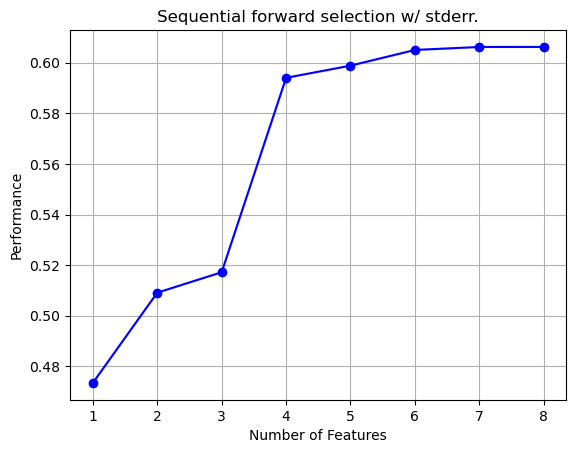

In [134]:

fig1= plot_sfs(sfs1.get_metric_dict(),kind='std_dev')
plt.title('Sequential forward selection w/ stderr.')
plt.grid(True)
plt.show()

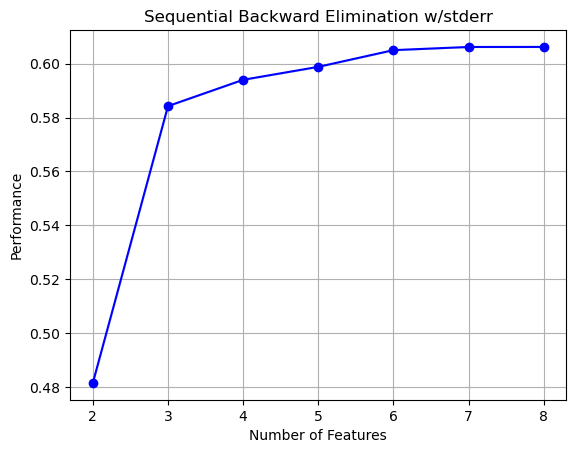

In [133]:
fig2= plot_sfs(sfs2.get_metric_dict(),kind='std_dev')
plt.title('Sequential Backward Elimination w/stderr')
plt.grid(True)
plt.show()

In [191]:
# Create the SequentialFeatureSelector instance
sfs3 = SequentialFeatureSelector(
    LinearRegression(),
    k_features=(2, 8),
    forward=False,
    floating=False,
    cv=0
)

# Initialize lists to store scores and iteration times
scores = []
iteration_times = []

# Start the SFS process
for k in range(2, 9):  # Selecting 2 to 8 features
    start_time = time.time()  # Record the start time
    sfs3.k_features = k
    sfs3.fit(data, target)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the time consumed
    iteration_times.append(elapsed_time)
    scores.append(sfs3.k_score_)

In [192]:
iteration_times

[0.1235189437866211,
 0.10851716995239258,
 0.09755468368530273,
 0.08651590347290039,
 0.0665125846862793,
 0.04199934005737305,
 0.005998134613037109]

In [193]:
scores

[0.48146332483945653,
 0.5842592625783574,
 0.5940250548052655,
 0.5988375576365013,
 0.6050397785905599,
 0.6062193051855558,
 0.606232685199805]

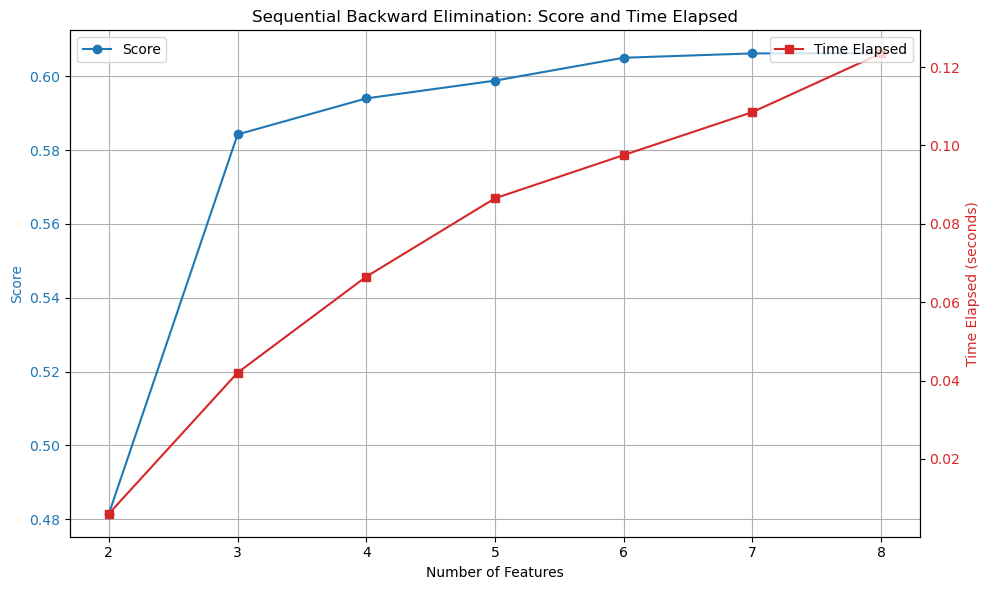

In [198]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the score on the primary y-axis
ax1.plot(range(2, 9), scores, color='tab:blue', marker='o', label='Score')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Score', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for elapsed times
ax2 = ax1.twinx()
ax2.plot(range(2, 9), iteration_times[-1::-1], color='tab:red', marker='s', label='Time Elapsed')
ax2.set_ylabel('Time Elapsed (seconds)', color='tab:red')

ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Sequential Backward Elimination: Score and Time Elapsed')
fig.tight_layout()

# Show the plot
ax1.grid(True)
ax2.grid(False)
plt.show()